<a href="https://colab.research.google.com/github/valentinaslisser/valentina_slisser/blob/main/HW2_VS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification using Gaussian distributions

For this weeks assignment, you will implement a *classification* algorithm, which is the other main type of *supervised learning* algorithm (as opposed to *regression*, from last week). Specificially, you will build a *Bayes classifier* using *Gaussian distributions* to estimate the likelihood of continuous variables.

For this we will work with a classic dataset from machine learning; Fisher's Iris dataset. The dataset contains the measurements of *length* and *width* of the *sepals* and *petals* of 150 flowers.

<img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Petal-sepal.jpg" width=250>

Using these 4 attributes (*length* and *width* of both *sepals* and *petals*), the flowers should then be classified as as one of 3 species of Iris flower:

* Iris setosa
* Iris versicolor
* Iris virginica

This dataset is such a classic example that it is even included in machine learning libraries such as [scikit-learn](http://scikit-learn.org/stable/index.html). For now, we will only use it to load in the dataset, but in later assignments we will use more of its capabilities. The code below should store and show the dataset as the variable `iris`.

In [37]:
# CodeGrade Tag init1
import math
import matplotlib.pylab as plt
import numpy as np

# Sets the random seed for Numpy such that Codegrade will have the same randomization
# DO NOT CHANGE THE LINE BELOW WHEN HANDING IN TO CODEGRADE!
RANDOM_SEED = 4

from sklearn import datasets

iris = datasets.load_iris()
print(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     

## Separate and plot the data [1 pt]

The `iris` variable now contains an object with all sorts of information about the dataset. The 2 most important atributes are *target* and *data* containing respectively the labels and the data points for the 150 flowers. An attribute of this data object can be accessed with **.** (e.g., `iris.data`).

Use this to create the matrix $X$ and the vector $R$. Then divide the matrix $X$ into 3 parts, `C0`, `C1` and `C2`, each containing the data for a different class, as labeled by the vector $R$. *Hint: Some clever [indexing](https://docs.scipy.org/doc/numpy/user/basics.indexing.html#boolean-or-mask-index-arrays) might help here.*

In [38]:
from sklearn.datasets import load_iris
import numpy as np

def separate_data(dataset):
    X = dataset.data
    R = dataset.target.reshape(-1, 1)  # make it (n_samples, 1)
    return X, R

def split_data(X, R):
    r_flat = R.ravel()  # use 1-D view for masking
    C0 = X[r_flat == 0]
    C1 = X[r_flat == 1]
    C2 = X[r_flat == 2]
    return C0, C1, C2

iris = load_iris()
X, R = separate_data(iris)
C0, C1, C2 = split_data(X, R)

# Assertions
assert (C0.shape[0] + C1.shape[0] + C2.shape[0]) == X.shape[0]
assert (C0.shape[0] + C1.shape[0] + C2.shape[0]) == R.shape[0]
assert R.shape[1] == 1, "Your R matrix does not have the correct shape!"


Lets plot this data, so we can see what it looks like. We have prepared some code below that plots a so-called scatter matrix. This is a matrix of scatter plots that can be used to easily identify correlations and see the seperability of the dataset. The diagonals of this plot show how the data is distributed for every *single* feature, while the non-diagonals show scatter plots using *two* of the features as the $x$ and $y$ axis, with all the different possible configurations shown in the matrix.

The different colors here correspond to the different classes of Iris, which is the same separation you just made, dividing the data points into $C_0$, $C_1$ and $C_2$.

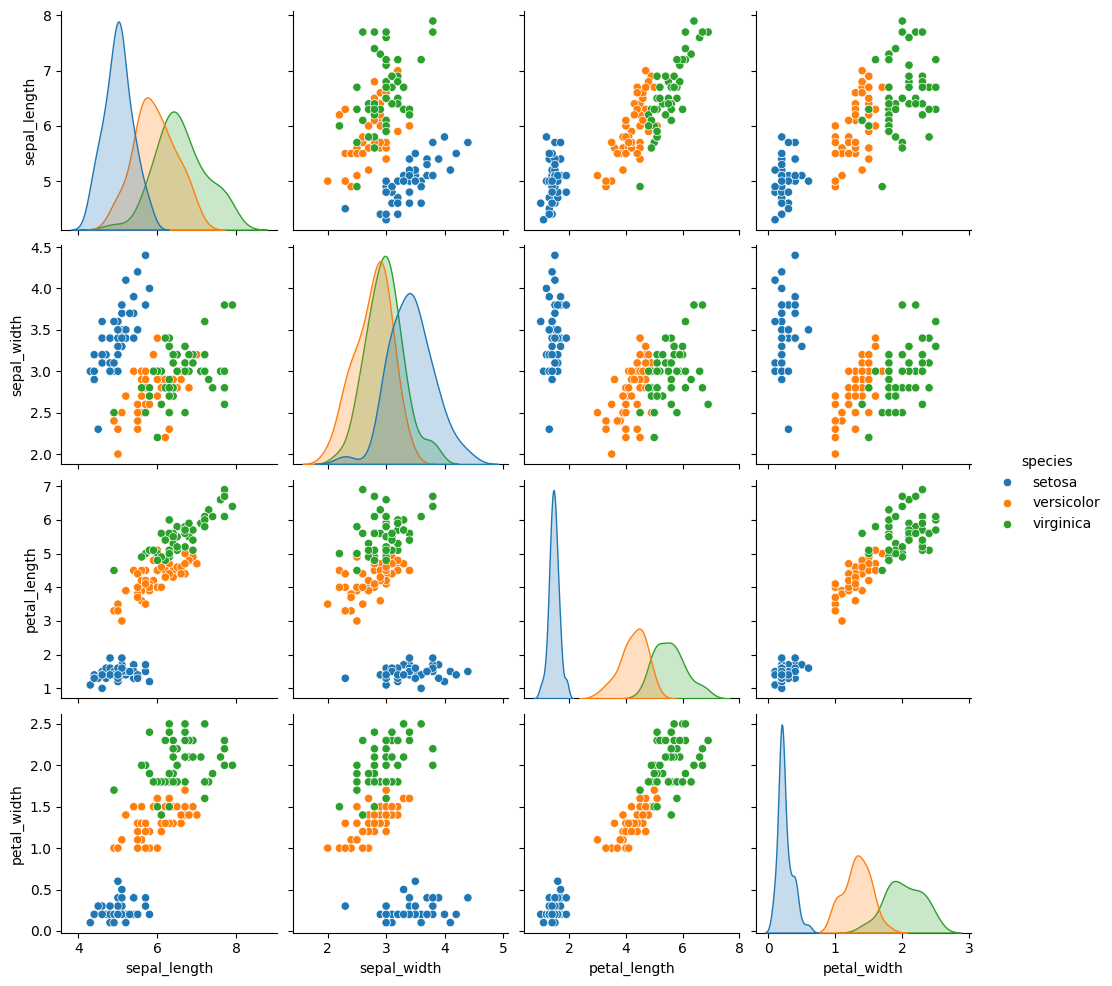

In [39]:
# CodeGrade Tag ignore seaborn
import seaborn as sns

df_iris = sns.load_dataset('iris')
sns.pairplot(df_iris, hue='species')
plt.show()

Looking at these plots, it should be quite clear that the Setosa species is more easily separated than Versicolor and Virginica. Also, it seems that quite a few of the variable combinations are correlated with each other.

## Inspect and estimate the correlations [1pt]

One measure of how variables are correlated is the covariance. The covariance between two jointly distributed real-valued random variables $X$ and $Y$  is defined as the expected product of their deviations from their individual expected values:

\begin{align}
\operatorname{cov}(X, Y)
&= \operatorname{E}\left[\left(X - \operatorname{E}\left[X\right]\right) \left(Y - \operatorname{E}\left[Y\right]\right)\right] \\
&= \operatorname{E}\left[X Y - X \operatorname{E}\left[Y\right] - \operatorname{E}\left[X\right] Y + \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]\right] \\
&= \operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right] + \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right] \\
&= \operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right],
\end{align}

When covariance is positive, this means that the variables are positively correlated: i.e. when one variable increases in value, it is probable that the other variable also increases. When covariance is negative, this means that the variables are negatively correlated: i.e. when one variable increases in value, it is probable that the other variable decreases. When covariance is near zero, there is no correlation between the variables.

In the cell below we have provided you with a small bit of code that should help you to fit a first Gaussian distribution to the Versicolor part of the data. The code generates some samples from a 2 dimensional Gaussian distribution, using a *mean vector* and a *covariance matrix* and plots those together with the data. The mean vector and both the standard deviations have already been provided, but to complete the covariance matrix, the covariance between the two features should also be set.

Together, this is enough to start generating samples, and the more the different distributions overlap, the better the fit of the generated distribution. Manually change the variable `covar` such that the distribution of the generated samples overlaps as much as possible with the real data.

/tmp/ipython-input-3017304170.py:25: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, size=100)


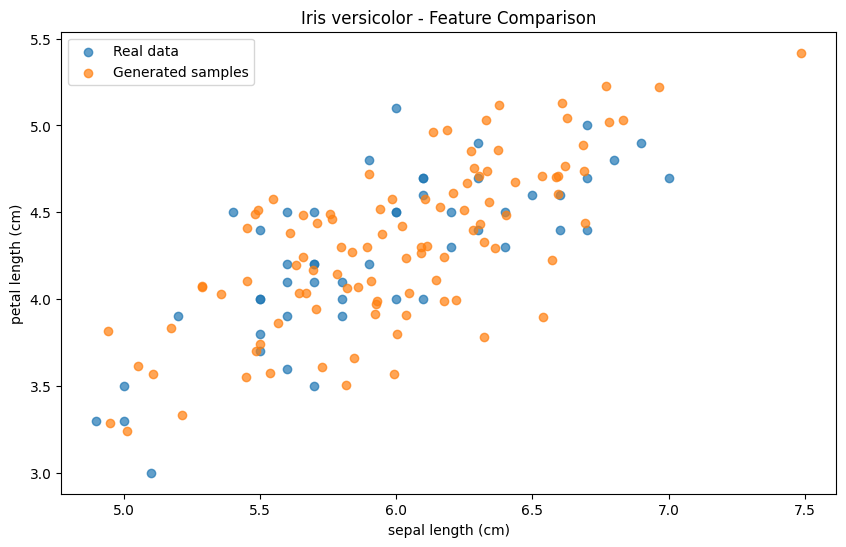

Covariance Matrix:
[[0.261104 0.3     ]
 [0.3      0.2164  ]]


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris()

target_class = 1

x_feature = 0  # sepal length
y_feature = 2  # petal length

C1 = iris.data[iris.target == target_class]

std_x = np.std(C1[:, x_feature])
std_y = np.std(C1[:, y_feature])

covar = 0.3

cov = np.array([[std_x**2, covar],
                [covar, std_y**2]])

mean = np.array([np.mean(C1[:, x_feature]),
                 np.mean(C1[:, y_feature])])

samples = np.random.multivariate_normal(mean, cov, size=100)

plt.figure(figsize=(10, 6))
plt.scatter(C1[:, x_feature], C1[:, y_feature], label='Real data', alpha=0.7)
plt.scatter(samples[:, 0], samples[:, 1], label='Generated samples', alpha=0.7)

plt.title(f'Iris {iris.target_names[target_class]} - Feature Comparison')
plt.xlabel(iris.feature_names[x_feature])
plt.ylabel(iris.feature_names[y_feature])
plt.legend()
plt.show()

print("Covariance Matrix:")
print(cov)

*How do the values of `std_x` and `std_y` affect the shape of the resulting distribution?*

A larger standard deviation results in a more spread-out distribution and a smaller standard deviation creates a more concentrated, compact distribution
In the covariance matrix

*How are the sepal length and petal length correlated for the Versicolor class?*

There is a positive correlation between sepal length and petal length for the Iris Versicolor class. As sepal length increases, petal length also increases and the covariance matrix shows a positive covariance of 0.3, indicating this positive correlation. The scatter plot confirms this relationship, with points showing a upward linear trend. This means that for Versicolor Iris flowers, longer sepals are typically associated with longer petals.



*How do the values of `std_x` and `std_y` affect the shape of the resulting distribution?*

A larger standard deviation results in a more spread-out distribution and a smaller standard deviation creates a more concentrated, compact distribution
In the covariance matrix

*How are the sepal length and petal length correlated for the Versicolor class?*

There is a positive correlation between sepal length and petal length for the Iris Versicolor class. As sepal length increases, petal length also increases and the covariance matrix shows a positive covariance of 0.3, indicating this positive correlation. The scatter plot confirms this relationship, with points showing a upward linear trend. This means that for Versicolor Iris flowers, longer sepals are typically associated with longer petals.


## Validation sets [1 pt]

Now that we have an idea what our dataset looks like, our goal is to create a model that will predict the class (in this case iris species) based on the other variables. In order to evaluate how well the model fits, we will also need a validation set where we can test some of our predictions. For this we will again split the data into a training and a validation set. Fill in the function below, you can use your function from last week as inspiration. This time, rather than randomly shuffling your data at each run, please use the `fixed_order` given below to shuffle your data accordingly.

Now use this function on the data from each of the 3 classes, using a ratio of $0.7$ for each. This should result in 3 different training sets and 3 different validation sets. Be sure to name them all differently, so you can still use them all later in the assignment.

*Hint: In order to guarantee that the results of the shuffle are deterministic (and will not fail the autograder), please use the newer (default) [RNG Generator from Numpy](https://numpy.org/doc/2.3/reference/random/generated/numpy.random.Generator.shuffle.html#numpy.random.Generator.shuffle) to shuffle your data. The old method `np.random.shuffle()` appears to lead to inconsistent results. Use the RANDOM_SEED constant defined at the top of the file for the generator. Remember to make a COPY of the data and not shuffling in-place!*

In [41]:
def validation_split(data, ratio, seed):
    """
    Splits the data into a train & validation set.

    Input:
    data - A Numpy array containing the input data.
    ratio - A fixed ratio to use when dividing the data into two sets.
    seed - The seed set to ensure equal shuffling (DO NOT CHANGE WHEN HANDING IN TO CODEGRAGE!)

    Output:
    - 2 Numpy arrays, one for training & 1 for validation.
    """
    np.random.seed(seed)

    n_samples = data.shape[0]

    n_train = int(n_samples * ratio)
    n_val = n_samples - n_train

    rng = np.random.default_rng(seed)

    shuffled_data = data.copy()
    rng.shuffle(shuffled_data)

    train_data = shuffled_data[:n_train]
    val_data = shuffled_data[n_train:]

    return train_data, val_data






## Univariate model [1 pt]

Looking at the scatter matrix of the data from the previous section, you might conclude that separating the different classes would be a lot easier based on the petal data (3rd and 4th variable) than on the sepal data (1st and 2nd variable), as it easier to distinguish the different clusters in that plot. In fact, for now we will only focus on 1 variable, the **petal length (3rd variable)**, as it looks like it might be useful just on its own and this will simplify the model a lot.

Using the training data from each of 3 classes, compute the mean and standard deviation for the *petal length* attribute for each class. Use the variable names given in the print statements. The Maximum Likelihood Estimators for these are given by

(4.8a) $$m = \frac{\sum_{t=1}^Nx^t}{N}$$

(4.8b) $$s = \sqrt{\frac{\sum_{t=1}^N(x^t - m)^2}{N}}$$

You can also use the built-in *Numpy* functions for [mean](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html) and [standard deviation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html). Print the results for each class and make sure they make sense in comparison to the plot.

In [42]:
import numpy as np

def compute_mean(C: np.array, variable: int):
    """
    Computes the mean of the specified variable in the input array.

    Inputs:
    - C: Numpy array
    - variable: Index of the column (feature) to compute mean for

    Output:
    - Float mean value
    """
    return np.mean(C[:, variable])

def compute_std(C: np.array, variable: int):
    """
    Computes the standard deviation of the specified variable in the input array.

    Inputs:
    - C: Numpy array
    - variable: Index of the column (feature) to compute standard deviation for

    Output:
    - Float standard deviation value
    """
    return np.std(C[:, variable])

from sklearn.datasets import load_iris

iris = load_iris()

C0 = iris.data[iris.target == 0]
C1 = iris.data[iris.target == 1]
C2 = iris.data[iris.target == 2]

petal_length_var = 2

print("C0: mean=%.3f, std=%.3f" % (compute_mean(C0, petal_length_var),
                                   compute_std(C0, petal_length_var)))
print("C1: mean=%.3f, std=%.3f" % (compute_mean(C1, petal_length_var),
                                   compute_std(C1, petal_length_var)))
print("C2: mean=%.3f, std=%.3f" % (compute_mean(C2, petal_length_var),
                                   compute_std(C2, petal_length_var)))



C0: mean=1.462, std=0.172
C1: mean=4.260, std=0.465
C2: mean=5.552, std=0.546


## Probability density function [2 pts]

The probability density function for a Gaussian distribution is defined as

(4.7) $$p(x|\mu, \sigma)=\frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

where $X$ is Gaussian (normal) distributed with mean $\mu$ and variance $\sigma^2$, denoted as $\mathcal{N}(\mu,
\sigma^2$).

That means that if we have estimates for $\mu$ and $\sigma$, we can compute the probability density for a specific value $x$. Implement this in the function below.

You have already made estimates for $\mu$ and $\sigma$ for the *petal length* for each of the 3 classes, so we can now define PDFs for each separate class. Plot the 3 functions using [linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) for a range of x-values ($0\leq x\leq 7$, with 1000 generated samples) and apply the PDF functions to obtain the y-values. Use the previous plots to estimate a sensible range for *linspace* and make sure that the plotted densities correspond with your expectations.

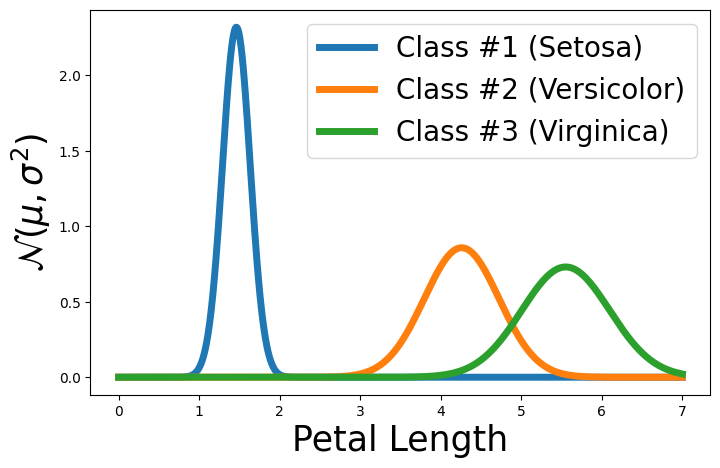

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import math

def normal_pdf(x: np.array, m: float, s: float):
    """
    Computes the Probability Density Function for a Gaussian distribution.

    Inputs:
    x - Numpy Array of x values
    m - Mean
    s - Standard Deviation

    Output:
    A Numpy array with the Gaussian PDF function applied to the content
    """
    return (1 / (s * np.sqrt(2 * np.pi))) * np.exp(-((x - m)**2) / (2 * s**2))

def x_axis():
    """
    Creates the proper X-axis to return.

    Output:
    A Numpy linspace array with the correct dimensions
    """
    return np.linspace(0, 7, 1000)


mean_C0_train = 1.462
std_C0_train = 0.172
mean_C1_train = 4.260
std_C1_train = 0.465
mean_C2_train = 5.552
std_C2_train = 0.546

x_grid = x_axis()

plt.figure(figsize=(8, 5))

plt.plot(x_grid, normal_pdf(x_grid, mean_C0_train, std_C0_train), '-', lw=5, label="Class #1 (Setosa)")
plt.plot(x_grid, normal_pdf(x_grid, mean_C1_train, std_C1_train), '-', lw=5, label="Class #2 (Versicolor)")
plt.plot(x_grid, normal_pdf(x_grid, mean_C2_train, std_C2_train), '-', lw=5, label="Class #3 (Virginica)")

plt.xlabel("Petal Length", fontsize=25)
plt.ylabel(r"$\mathcal{N}(\mu, \sigma^2)$", fontsize=25)
plt.legend(loc=0, fontsize=20)
plt.show()

## Posterior probabilities [2 pts]

The plot above shows the probability densities for a value $x$, provided that you know the parameters for a specific class $C_i$, i.e. $p(x | \mu_i, \sigma_i)$. Because the mean and standard deviation are suffient statistics for normally distributed data, this is equivalent to the probability density given that specific class $p(x | C_i)$. However, what would be useful for classification, is the posterior probabilities of the classes given the data, i.e. $P(C_i | x)$. We can use Bayes' rule for this

(3.5) $$P(C_i | x) =  \frac{p(x | C_i) P(C_i)}{p(x)} = \frac{p(x | C_i) P(C_i)}{\sum_{k=1}^K p(x | C_k) P(C_k)}$$

Because here we have no prior knowledge of the distribution of the different classes, we can just assume all prior class probabilities $P(C_i)$ to be equal. For our 3 class problem, that would mean a probability of $\frac{1}{3}$ for each class, but we can also just factor the common prior out of the equation and simplify to

$$P(C_i | x) = \frac{p(x | C_i)}{\sum_{k=1}^K p(x | C_k)}$$

In order to make the code a little easier to write, make a vector $m$ with all values of $m_i$ and vector $s$ with all values of $s_i$, where $m_i$ and $s_i$ are the estimates for the class $C_i$. You can then just use those 2 vectors and a parameter $i$ to indicate which class you want to compute the posterior for. Write the function for the `posteriors`. It should take as input a data array and return the posterior matrix of dimensions $N \times |C|$ where $N$ is the number of input points and $|C|$ is the total number of classes (3 in our case). Plot the posterior probabilities for all 3 classes. Does the plot of these 3 posteriors make sense based on the data?

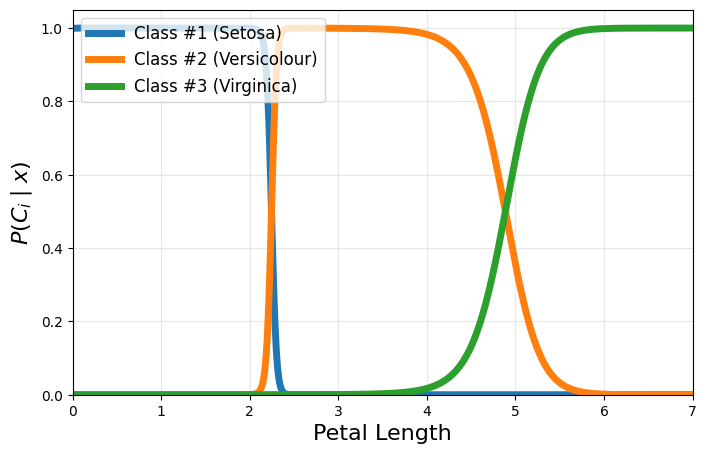

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

def posteriors(x, m, s):
    """
    Computes the Posterior probabilities for each class.

    Input:
      x : 1D array of N values (data/grid to evaluate)
      m : list/1D array of length K with means per class
      s : list/1D array of length K with stds per class

    Output:
      N x K array with P(C_k | x_n) for every n and class k.
      Each row (fixed n) sums to 1.
    """

    x = np.asarray(x).reshape(-1, 1)       # (N, 1)
    m = np.asarray(m).reshape(1, -1)       # (1, K)
    s = np.asarray(s).reshape(1, -1)       # (1, K)

    coeff = 1.0 / (np.sqrt(2.0 * np.pi) * s)                         # (1, K)
    z = (x - m) / s                                                  # (N, K)
    L = coeff * np.exp(-0.5 * (z ** 2))                              # (N, K)


    K = m.shape[1]
    priors = np.full((1, K), 1.0 / K)                                # (1, K)

    numerators = L * priors                                          # (N, K)


    denom = numerators.sum(axis=1, keepdims=True)                    # (N, 1)


    P = numerators / denom                                           # (N, K)
    return P


def vectorize_values(*args):
    """
    Vectorizes the given input arguments into one matrix.

    Input:
      *args : any number of 1D arrays of equal length N

    Output:
      (N, D) matrix whose columns are the provided arrays in order.
    """
    cols = [np.asarray(a).reshape(-1, 1) for a in args]  # make each a column
    return np.hstack(cols)


iris = load_iris()
X = iris.data
y = iris.target


C0 = X[y == 0]
C1 = X[y == 1]
C2 = X[y == 2]

means = [1.462, 4.260, 5.552]
stds = [0.172, 0.465, 0.546]

m = vectorize_values(*means)
s = vectorize_values(*stds)


x_grid = np.linspace(0, 7, 1000)
posts = posteriors(x_grid, m, s)


plt.figure(figsize=(8, 5))
plt.plot(x_grid, posts[:, 0], "-", lw=5, label="Class #1 (Setosa)")
plt.plot(x_grid, posts[:, 1], "-", lw=5, label="Class #2 (Versicolour)")
plt.plot(x_grid, posts[:, 2], "-", lw=5, label="Class #3 (Virginica)")
plt.xlabel("Petal Length", fontsize=16)
plt.ylabel(r"$P(C_i \mid x)$", fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.ylim([0, 1.05])
plt.xlim([0, 7])
plt.grid(True, alpha=0.3)
plt.show()

## Bayes Classifier [2 pts]

Now that we can compute the posteriors for every class, constructing a classifier is easy. The Bayes classifier is defined as

(3.6) $$choose\ C_i\ if\ P (C_i |x) = max_k\ P(C_k |x)$$

Write the code for the `classify` function. It should classify a single data point $x$ as one of the 3 classes, returning $0$, $1$ or $2$ based on the which class the flower is most likely to belong to. The other arguments of the function should therefore be the vector of mean estimates $m$ and the vector of standard deviation estimates $s$.

Next complete the `validate` function below. It should take a validation set, the expected class for all data points in that set and the vectors $m$ and $s$ with which to make the classifications. Based on this, it should return the percentage of elements in the validation set that were classified correctly.

Remember that the mean and standand deviation estimates we have computed are only based on the *petal length* variable, while a data point in the validation set consists of a complete row, i.e. all 4 variables describing the dimensions of a flower instance. So, for now, you will only need to use the *petal length* variable from each data point to attempt to classify it.

Apply the `validate` function to all 3 validation sets and report the percentage correct for each class. Also include the average correct percentage for all 3 classes.

In [45]:
import numpy as np

def classify(x, m, s):
    """
    Classify the input data using the previously defined posteriors() function.

    Inputs:
    x - The input data
    m - The vectorized means
    s - The vectorized STDs

    Output:
    A Numpy array containing the predicted targets
    """
    posts = posteriors(x, m, s)

    predicted_targets = np.argmax(posts, axis=1)

    return predicted_targets

def validate(val, expected, m, s):
    """
    Computes the accuracy of classification against the validation set.

    Inputs:
    val - validation input data
    expected - the correct targets for each position
    m - The vectorized means
    s - The vectorized STDs

    Output:
    A float representing the accuracy against the validation set
    """
    predictions = classify(val, m, s)

    class_accuracies = []
    for c in range(3):
        class_mask = (expected == c)

        class_accuracy = np.mean(predictions[class_mask] == expected[class_mask])
        class_accuracies.append(class_accuracy)

    avg_accuracy = np.mean(class_accuracies)

    print("C0: Accuracy = %.3f" % class_accuracies[0])
    print("C1: Accuracy = %.3f" % class_accuracies[1])
    print("C2: Accuracy = %.3f" % class_accuracies[2])

    return avg_accuracy

from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data[:, 2]
y = iris.target

X_train, X_val = validation_split(X.reshape(-1, 1), ratio=0.7, seed=RANDOM_SEED)
y_train, y_val = validation_split(y.reshape(-1, 1), ratio=0.7, seed=RANDOM_SEED)

X_val = X_val.ravel()


means = [1.462, 4.260, 5.552]
stds = [0.172, 0.465, 0.546]

m = vectorize_values(*means)
s = vectorize_values(*stds)

accuracy = validate(X_val, y_val.ravel(), m, s)
print("Avg Accuracy = %.3f" % accuracy)


C0: Accuracy = 1.000
C1: Accuracy = 0.938
C2: Accuracy = 0.938
Avg Accuracy = 0.958


# Multivariate distributions

You should already get pretty good results using just the *petal length* variable (depending on the splits that were made for the validation sets, the exact percentage might vary a little), but maybe we can do better still. Looking at the original plots of the data, you might conclude that there could be more information for the classification in the other variables, so a multi-variate approach would make sense. This means we will need a multi-variate version of the probability density function for normal distributions, which is defined as

(5.9) $$p(\boldsymbol{x}|\boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{\frac{d}{2}}|\boldsymbol{\Sigma}|^{\frac{1}{2}}} e^{-\frac{1}{2}(\boldsymbol{x} - \boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\boldsymbol{x} - \boldsymbol{\mu})}$$

where $\boldsymbol{x}$ is a $d$-dimensional vector drawn from the normal distribution $\mathcal{N}_d(\boldsymbol{\mu}, \boldsymbol{\Sigma})$, with mean vector $\boldsymbol{\mu}$ and covariance matrix $\boldsymbol{\Sigma}$.

If we used all 4 variables in the dataset to compute the vector of means and the covariance matrix for each class, then we could use the above equation to compute the probability densities for each class, with those the posteriors for each class and finally use the same Bayes classifier to select the most probable class for a data point. However if the number of variables is large, then the number parameters for the covariance matrix (sized $d \times d$) can become too large to properly fit to the amount of data we have. It is therefore common to make some simplifying assumptions, to decrease the complexity of the model. One well know variant is *Naive Bayes*, where the assumption is that all variables are independent. This means the model only uses the variance for each variable and no covariances are included, which corresponds to a covariance matrix with only entries on the diagonal.

## Naive bivariate distributions [4 pts]

We will start with a bi-variate (i.e. 2 variables) distribution, as this will be easier to plot, visualize, and thus reason about. Looking at the original 2 plots of the data, the second plot using the *petal length* and *petal width* seems to result in nice clusters, so will use those 2 variables.  We will use the *Naive Bayes* model for our bivariate data. Even if computing the covariance might not be problematic in this case, it will still be useful to see the effect of such a simplifying assumption.

This assumption of independence might be *naive* using real world data, you might even expect *length* and *width* of flower petals to be strongly correlated, but it turns out *Naive Bayes* can still make an effective classifier. The assumption of independence also simplifies the equation a lot: Instead of writing out the full version using the covariance matrices, we can write a multi-variate distribution as a product of one-dimensional distributions for each variable. So for our 2 variable case:

$$p(\boldsymbol{x}| C_i) = p(x_1 | C_i) p(x_2 | C_i)$$

Where $p(x_1 | C_i)$ is the old univariate distribution using the $\mu_1$ and $\sigma_1$ parameters of the first variable for class $C_i$ and $p(x_2 | C_i)$ is the same equation using the $\mu_2$ and $\sigma_2$ parameters of the second variable for class $C_i$.

Start by writing this *naive* version of the probability density function for the bivariate case. You will also have to compute the 3 means (for each of the 3 classes) and 3 standard deviations for the additional *petal width* variable. You should already have the code to compute these for the *petal length* variable from the univariate distributions.

Now we will plot the density for each class to see what they look like. These plots will be a 3-dimensional; 2 dimensions for the values of *petal length* and *petal width*, and 1 dimension for the probability density belonging to that combination of variables. There are several ways to make 3d plots in *matplotlib*; we will use contour plots, as that is also what is used most in the book (see figure 5.3, 5.4, 5.5 and 5.6). Start with a simple plot of the point values of the 2 variables using a different color for each class (like at the start of the assignment) and overlay the 3 contours on top of them.

Construct a mesh of X and Y values using [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) for each dimension and combining them with [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html). Then compute the Z values for a probability density function of 1 class and use the [contour](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html) function to plot those Z values. Repeat this for the other 2 classes and show the final plot. You can also look at some demo uses of contour [here](https://matplotlib.org/stable/gallery/images_contours_and_fields/contour_demo.html).

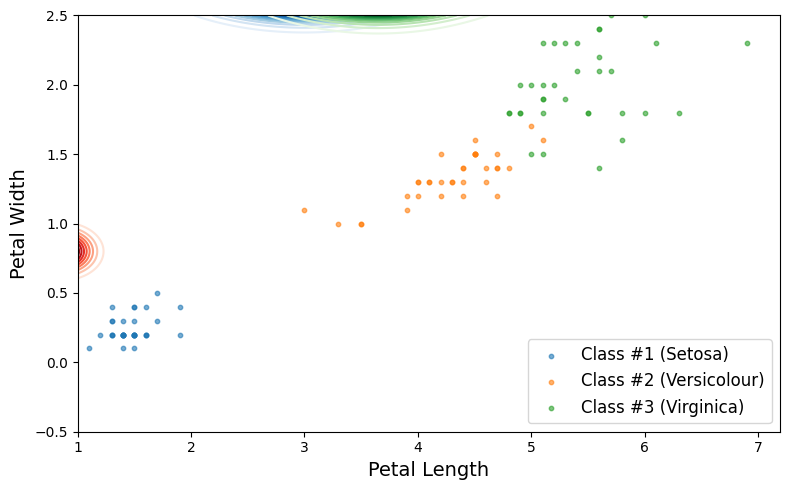

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------

def normal_pdf(x, m, s):
    x = np.asarray(x)
    return (1.0 / (s * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - m) / s)**2)

def naive_bivar_normal_pdf(x1, x2, m1, m2, s1, s2):
    """
    Naive bivariate normal PDF: p(x1, x2 | C) = p(x1 | C) * p(x2 | C)
    Works with vectors or with 2D meshgrid arrays (broadcast-safe).
    """
    return normal_pdf(x1, m1, s1) * normal_pdf(x2, m2, s2)

def _ensure_iterable_cols(variables):
    idx = np.asarray(variables)
    if idx.ndim == 0:      # single int -> make length-1 array
        idx = idx[None]
    return idx.astype(int)

def compute_mean_multiclass(C, variables):

    if np.isscalar(variables):
        variables = [variables]

    means = []
    for cls in C:
        class_means = [np.mean(cls[var]) for var in variables]
        means.append(class_means)

    return np.array(means)



def compute_std_multiclass(C: np.ndarray, variables, ddof=0):
    """
    Same interface as compute_mean_multiclass; returns std(s).
    """
    C = np.asarray(C)
    idx = _ensure_iterable_cols(variables)
    stds = np.std(C[:, idx], axis=0, ddof=ddof)
    return float(stds[0]) if len(idx) == 1 else stds



from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

C0 = X[y == 0]
C1 = X[y == 1]
C2 = X[y == 2]



RANDOM_SEED = 4
ratio = 0.7

C0_train, C0_val = validation_split(C0, ratio=ratio, seed=RANDOM_SEED)
C1_train, C1_val = validation_split(C1, ratio=ratio, seed=RANDOM_SEED)
C2_train, C2_val = validation_split(C2, ratio=ratio, seed=RANDOM_SEED)


variables = [2, 3]

C0_train = C0_train[:, variables]
C1_train = C1_train[:, variables]
C2_train = C2_train[:, variables]

mean_C0_train_multi = compute_mean_multiclass([C0_train], [0, 1])
mean_C1_train_multi = compute_mean_multiclass([C1_train], [0, 1])
mean_C2_train_multi = compute_mean_multiclass([C2_train], [0, 1])

std_C0_train_multi  = compute_std_multiclass(C0_train, [0, 1])
std_C1_train_multi  = compute_std_multiclass(C1_train, [0, 1])
std_C2_train_multi  = compute_std_multiclass(C2_train, [0, 1])


means_length = np.array([mean_C0_train_multi[0, 0], mean_C1_train_multi[0, 0], mean_C2_train_multi[0, 0]])
means_width = np.array([mean_C0_train_multi[0, 1], mean_C1_train_multi[0, 1], mean_C2_train_multi[0, 1]])

stds_length = np.array([std_C0_train_multi[0], std_C1_train_multi[0], std_C2_train_multi[0]])
stds_width = np.array([std_C0_train_multi[1], std_C1_train_multi[1], std_C2_train_multi[1]])

grid_size = 1000
x = np.linspace(1.0, 6.5, grid_size)   # petal length range
y = np.linspace(-0.5, 2.5, grid_size)  # petal width range
X_grid, Y_grid = np.meshgrid(x, y, indexing='xy')  # both shape (grid_size, grid_size)


pdf_C0 = naive_bivar_normal_pdf(
    X_grid, Y_grid,
    m1=means_length[0], m2=means_width[0],
    s1=stds_length[0],  s2=stds_width[0]
)
pdf_C1 = naive_bivar_normal_pdf(
    X_grid, Y_grid,
    m1=means_length[1], m2=means_width[1],
    s1=stds_length[1],  s2=stds_width[1]
)
pdf_C2 = naive_bivar_normal_pdf(
    X_grid, Y_grid,
    m1=means_length[2], m2=means_width[2],
    s1=stds_length[2],  s2=stds_width[2]
)


plt.figure(figsize=(8, 5))


plt.scatter(C0_train[:, 0], C0_train[:, 1], s=10, alpha=0.6, label="Class #1 (Setosa)")
plt.scatter(C1_train[:, 0], C1_train[:, 1], s=10, alpha=0.6, label="Class #2 (Versicolour)")
plt.scatter(C2_train[:, 0], C2_train[:, 1], s=10, alpha=0.6, label="Class #3 (Virginica)")


cp0 = plt.contour(X_grid, Y_grid, pdf_C0, levels=10, cmap="Reds")
cp1 = plt.contour(X_grid, Y_grid, pdf_C1, levels=10, cmap="Blues")
cp2 = plt.contour(X_grid, Y_grid, pdf_C2, levels=10, cmap="Greens")

plt.legend(loc=4, fontsize=12)
plt.xlabel("Petal Length", fontsize=14)
plt.ylabel("Petal Width", fontsize=14)
plt.tight_layout()
plt.show()

## Naive classifier [4 pts]

Now that you have the naive bivariate version of the pdf fuctions, constructing the *Naive Bayes* classifier will be straightforward. Simply adapt your previous `posteriors`, `classify` and `validate` functions to work with your `naive_bivar_normal_pdf` function.

Show the validation results for each of the 3 classes and the average over all 3 classes.

In [47]:
import numpy as np

def posteriors_naive(x1, x2, m1, m2, s1, s2):
    """
    Computes the Naive Posterior probabilities for each class.

    Inputs:
      x1, x2 : arrays of shape (N,) — feature values (e.g., petal length, petal width)
      m1, m2 : arrays of shape (K,) — class means for feature 1 and 2
      s1, s2 : arrays of shape (K,) — class stds  for feature 1 and 2

    Output:
      (N, K) array with P(C_k | x_n); each row sums to 1
    """
    x1 = np.asarray(x1).ravel()
    x2 = np.asarray(x2).ravel()
    m1 = np.asarray(m1).ravel()
    m2 = np.asarray(m2).ravel()
    s1 = np.asarray(s1).ravel()
    s2 = np.asarray(s2).ravel()

    K = m1.shape[0]
    N = x1.shape[0]


    L = np.zeros((N, K))
    for k in range(K):
        L[:, k] = naive_bivar_normal_pdf(x1, x2, m1[k], m2[k], s1[k], s2[k])


    priors = np.full((1, K), 1.0 / K)


    numerators = L * priors                 # (N, K)
    denom = numerators.sum(axis=1, keepdims=True)  # (N, 1)
    return numerators / denom               # rows sum to 1


def classify_naive(x1, x2, m1, m2, s1, s2):
    """
    Returns predicted class indices of shape (N,).
    """
    P = posteriors_naive(x1, x2, m1, m2, s1, s2)
    return np.argmax(P, axis=1)


def validate_naive(val, expected, m1, m2, s1, s2, labels=("C0", "C1", "C2")):
    """
    Prints per-class accuracy and the average; returns (avg_accuracy, [acc_C0, acc_C1, acc_C2]).
    """
    val = np.asarray(val)
    expected = np.asarray(expected).ravel()

    x1 = val[:, 0]
    x2 = val[:, 1]
    preds = classify_naive(x1, x2, m1, m2, s1, s2)

    K = len(m1)
    class_accs = []
    for c in range(K):
        mask = (expected == c)
        if mask.any():
            acc = float(np.mean(preds[mask] == expected[mask]))
        else:
            acc = float("nan")
        class_accs.append(acc)
        print(f"{labels[c]}: Accuracy = {acc:.3f}")

    avg = float(np.nanmean(class_accs))
    print(f"Avg. Accuracy = {avg:.3f}")
    return avg, class_accs


X_val = np.concatenate((C0_val, C1_val, C2_val))

y_val = np.concatenate((np.zeros(C0_val.shape[0]), np.ones(C1_val.shape[0]), np.full(C2_val.shape[0], 2)))

y_val = y_val.astype(int)


avg_acc, per_class = validate_naive(
    X_val, y_val,
    means_length, means_width,
    stds_length, stds_width
)

C0: Accuracy = 0.000
C1: Accuracy = 0.267
C2: Accuracy = 0.933
Avg. Accuracy = 0.400


## Decision boundaries [1 pt]

In *Alpaydin* the posterior equations are simplified as much as possible into a discriminant function, while still retaining the property

$$g_i(x) > g_j(x) \iff P(x|C_i) > P(x|C_j)$$

This can simplify the computation, or help gain insight in the actual distinguishing elements of the particular model. With some algebra, they can also be written into equations for the decision boundaries (the line where $g_i(x) = g_j(x)$). As we have a computer at our disposal, we won't worry too much about how many computations are needed and just let the machine do the work. If you make a contour plot of the complete posterior, these contours should also meet at the decision boundary, while being a lot less work to program.

For the previous cell you already wrote the `posteriors_naive` function, so all that is left is to make contour plots just like for the `naive_bivar_normal_pdf` function. Show the points for the 3 classes again and overlay the 3 posterior contours on top. Do the decision regions look like you would expect?

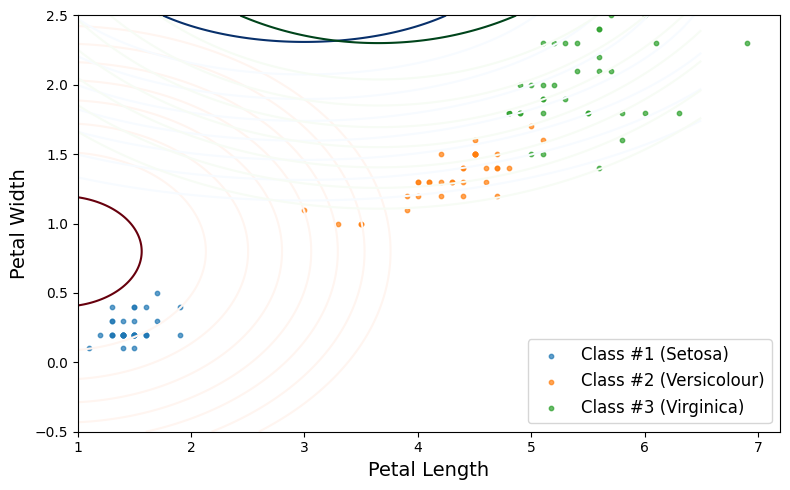

In [48]:

grid_size = 1000
x = np.linspace(1.0, 6.5, grid_size)
y = np.linspace(-0.5, 2.5, grid_size)
X, Y = np.meshgrid(x, y, indexing='xy')

pdf_C0 = naive_bivar_normal_pdf(X, Y, means_length[0], means_width[0], stds_length[0], stds_width[0])
pdf_C1 = naive_bivar_normal_pdf(X, Y, means_length[1], means_width[1], stds_length[1], stds_width[1])
pdf_C2 = naive_bivar_normal_pdf(X, Y, means_length[2], means_width[2], stds_length[2], stds_width[2])

def levels_from(pdf, n=8):
    qs = np.linspace(0.6, 0.98, n)
    return np.quantile(pdf, qs)

L0 = levels_from(pdf_C0)
L1 = levels_from(pdf_C1)
L2 = levels_from(pdf_C2)

plt.figure(figsize=(8,5))


plt.scatter(C0_train[:,0], C0_train[:,1], s=10, alpha=0.7, label="Class #1 (Setosa)")
plt.scatter(C1_train[:,0], C1_train[:,1], s=10, alpha=0.7, label="Class #2 (Versicolour)")
plt.scatter(C2_train[:,0], C2_train[:,1], s=10, alpha=0.7, label="Class #3 (Virginica)")


plt.contour(X, Y, pdf_C0, levels=L0, cmap="Reds")
plt.contour(X, Y, pdf_C1, levels=L1, cmap="Blues")
plt.contour(X, Y, pdf_C2, levels=L2, cmap="Greens")

plt.legend(loc=4, fontsize=12)
plt.xlabel("Petal Length", fontsize=14)
plt.ylabel("Petal Width", fontsize=14)
plt.tight_layout()
plt.show()


## Full bivariate distribution [3 pts]

Finally, we will compare this naive bivariate distribution with a full bivariate distribution, using the complete covariance matrix. In order to skip programming out the complete equations for this, you may use a built-in function, namely [multivariate normal distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) from the *SciPy* stats module. With this we can create a distribution based on a mean vector and a covariance matrix. This distribution can then be used to compute the probability density for a vector of x values, like so:

    distribution = multivariate_normal(mean=mean_vector, cov=covariance_matrix)
    prob_density = distribution.pdf(x_vector)

The mean vector and covariance matrix for a class can be computed using the *Numpy* functions [mean](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html) and [covariance](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html).

Create 3 distributions, one for each class, using the functions linked above. Write the `full_bivar_normal_pdf` function, which takes a `distr` argument that should correspond to one distribution for a class. Use that distribution to compute the probability density of the pair `x1`, `x2`.

Again plot the points for the 3 classes, using different colors for each class and overlay the contours of the probability densities for each of the 3 classes using a meshgrid. This should be the same as your contour plot for the naive bivariate distribution, only now using the full bivariate distribution to compute the densities.

*What is the difference between these 2 plots? Why?*

__YOUR ANSWER HERE__

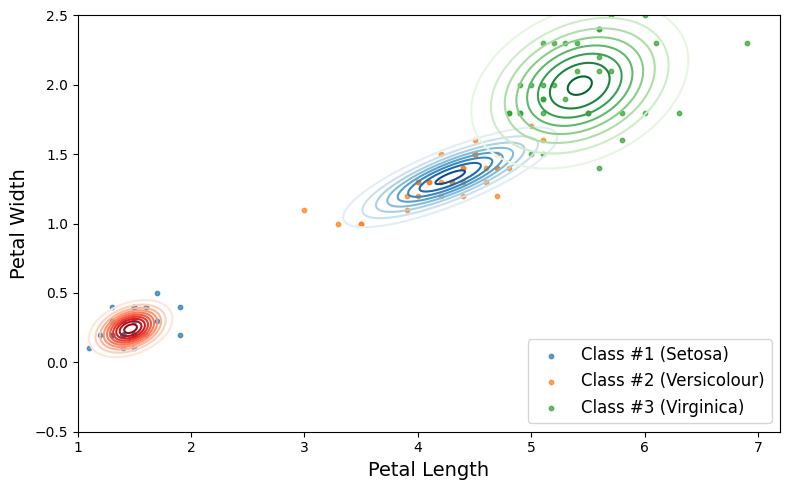

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


def full_bivar_normal_pdf(x1, x2, distr):
    """
    Evaluate the full bivariate PDF given a scipy.stats multivariate_normal `distr`.
    Accepts either vectors or meshgrid arrays for x1, x2 and returns a 2D array
    matching their broadcast shape.
    """
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)


    X1, X2 = np.broadcast_arrays(x1, x2)
    pts = np.column_stack([X1.ravel(), X2.ravel()])
    z = distr.pdf(pts).reshape(X1.shape)
    return z

def create_distribution(mean, C, seed):
    return multivariate_normal(
        mean=mean,
        cov=np.cov(C.T),
        seed=seed
    )




mu0 = np.mean(C0_train, axis=0)
mu1 = np.mean(C1_train, axis=0)
mu2 = np.mean(C2_train, axis=0)

distribution_C0 = create_distribution(mu0, C0_train, RANDOM_SEED)
distribution_C1 = create_distribution(mu1, C1_train, RANDOM_SEED)
distribution_C2 = create_distribution(mu2, C2_train, RANDOM_SEED)



grid_size = 1000
x = np.linspace(1.0, 6.5, grid_size)
y = np.linspace(-0.5, 2.5, grid_size)
X, Y = np.meshgrid(x, y, indexing="xy")

pdf_C0 = full_bivar_normal_pdf(X, Y, distribution_C0)
pdf_C1 = full_bivar_normal_pdf(X, Y, distribution_C1)
pdf_C2 = full_bivar_normal_pdf(X, Y, distribution_C2)



plt.figure(figsize=(8, 5))


plt.scatter(C0_train[:, 0], C0_train[:, 1], s=10, alpha=0.7, label="Class #1 (Setosa)")
plt.scatter(C1_train[:, 0], C1_train[:, 1], s=10, alpha=0.7, label="Class #2 (Versicolour)")
plt.scatter(C2_train[:, 0], C2_train[:, 1], s=10, alpha=0.7, label="Class #3 (Virginica)")


plt.contour(X, Y, pdf_C0, levels=10, cmap="Reds")
plt.contour(X, Y, pdf_C1, levels=10, cmap="Blues")
plt.contour(X, Y, pdf_C2, levels=10, cmap="Greens")

plt.legend(loc=4, fontsize=12)
plt.xlabel("Petal Length", fontsize=14)
plt.ylabel("Petal Width", fontsize=14)
plt.tight_layout()
plt.show()

## Full bivariate classifier [3 pts]

Adapt your `posteriors`, `classify` and `validate` functions to work your `full_bivar_normal_pdf` function. Each function should take a `distrs` argument, which should be a list containing the 3 `multivariate_normal` distributions for the 3 classes.

Show the validation results for each of the 3 classes and the average over all 3 classes.

In [50]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal

def posteriors_full(x, distrs):
    """
    Computes the posteriors of the multivariate classifier.

    Inputs:
    x - The input data
    distrs - The multivariate normal distributions

    Output:
    A Numpy array containing the posteriors applied to the input data
    """
    k = len(distrs)
    likelihoods = np.zeros((x.shape[0], k))
    priors = np.ones(k) / k

    for i in range(k):
        likelihoods[:, i] = distrs[i].pdf(x)

    posteriors = likelihoods * priors
    posteriors /= posteriors.sum(axis=1)[:, np.newaxis]

    return posteriors

def classify_full(x, distrs):
    """
    Classify the input data based on the given distributions.

    Inputs:
    x - Input data
    distrs - Distributions used to classify the data

    Output:
    A Numpy array containing the estimated classes
    """
    posts = posteriors_full(x, distrs)
    predicted_targets = np.argmax(posts, axis=1)
    return predicted_targets

def validate_full(val, expected, distrs):
    """
    Validates the predicted targets using the distribution.

    Inputs:
    val - Validation input data
    expected - True targets of the classification
    distrs - Given distributions used in classification

    Output:
    The accuracy of the output measured against the validation set
    """
    predictions = classify_full(val, distrs)
    class_accuracies = []

    for c in range(len(distrs)):
        class_mask = (expected == c)
        class_accuracy = np.mean(predictions[class_mask] == expected[class_mask])
        class_accuracies.append(class_accuracy)
        print(f"C{c}: Accuracy = {class_accuracy:.3f}")

    avg_accuracy = np.mean(class_accuracies)
    print(f"Avg. Accuracy = {avg_accuracy:.3f}")

    return avg_accuracy

np.random.seed(42)

iris = load_iris()
X = iris.data[:, 2:4]
y = iris.target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

means = np.array([
    np.mean(X_train[y_train == c], axis=0)
    for c in range(3)
])

distributions = [
    multivariate_normal(mean=means[c], cov=np.cov(X_train[y_train == c].T))
    for c in range(3)
]

validate_full(X_val, y_val, distributions)

C0: Accuracy = 1.000
C1: Accuracy = 1.000
C2: Accuracy = 1.000
Avg. Accuracy = 1.000


np.float64(1.0)